<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/SmallCap_Nifty_Corr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quandl

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import quandl
import pandas as pd
import numpy as np
import requests
from quandl.errors.quandl_error import NotFoundError
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn import preprocessing
import matplotlib


In [3]:
startdate='2003-04-01'

In [4]:
bse_100=quandl.get('BSE/'+ 'BSE100',start_date=startdate, authtoken="1Mz3xLNFNdUpKENCkArB")

In [5]:
bse_100.head(2)

,Open,High,Low,Close
Date,,,,
2003-04-01,867.16,883.17,867.16,879.88
2003-04-02,881.04,894.53,881.04,893.08


In [6]:
bse_sml=quandl.get('BSE/'+ 'BSESML',start_date=startdate, authtoken="1Mz3xLNFNdUpKENCkArB")

In [7]:
data_subset=pd.DataFrame()
# data.insert(column position , column name , series_to_be_inserted)
data_subset.insert(0,'bse_100',bse_100['Close'])
data_subset.insert(1,'bse_sml',bse_sml['Close'])

In [8]:
data_subset.tail(2)

,bse_100,bse_sml
Date,,
2021-08-27,16934.90,26284.15
2021-08-30,17178.24,26690.28


In [9]:
data_subset.columns=['close','close1']

In [10]:
data_subset.tail(2)

,close,close1
Date,,
2021-08-27,16934.90,26284.15
2021-08-30,17178.24,26690.28


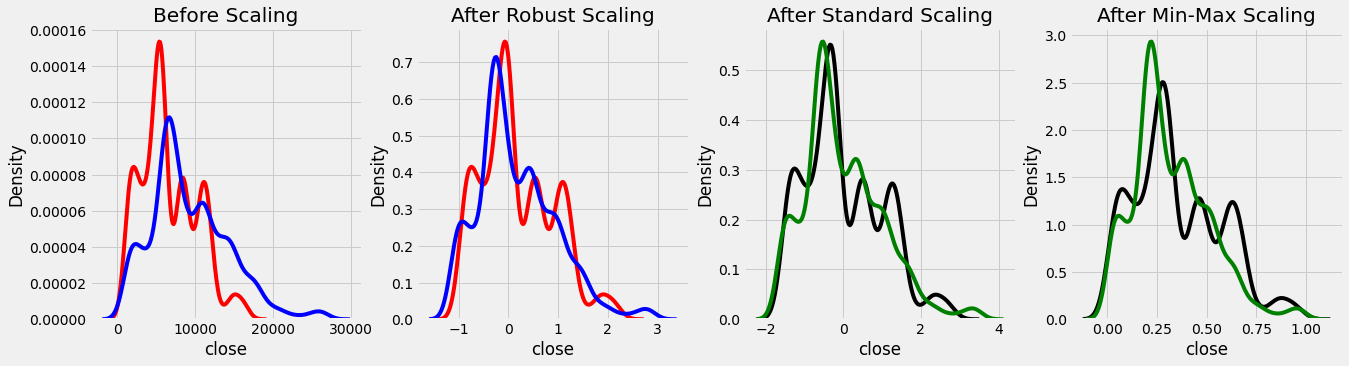

In [11]:
% matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset.copy()
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['close'], ax = ax1, color ='r')
sns.kdeplot(x['close1'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['close'], ax = ax2, color ='red')
sns.kdeplot(robust_df['close1'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['close'], ax = ax3, color ='black')
sns.kdeplot(standard_df['close1'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['close'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['close1'], ax = ax4, color ='g')
plt.show()

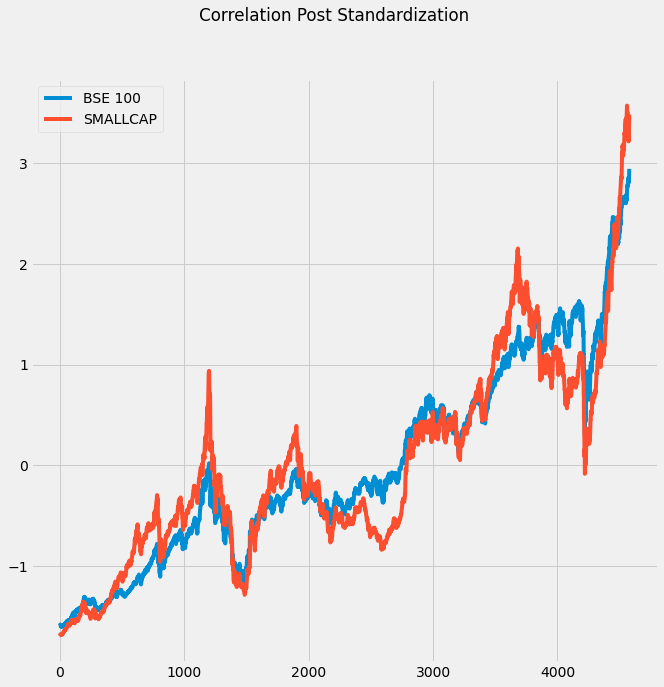

In [12]:
columns=['BSE 100','SMALLCAP']
standard_df.columns=columns
standard_df[:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

In [13]:
standard_df['diff']=standard_df['SMALLCAP']-standard_df['BSE 100']

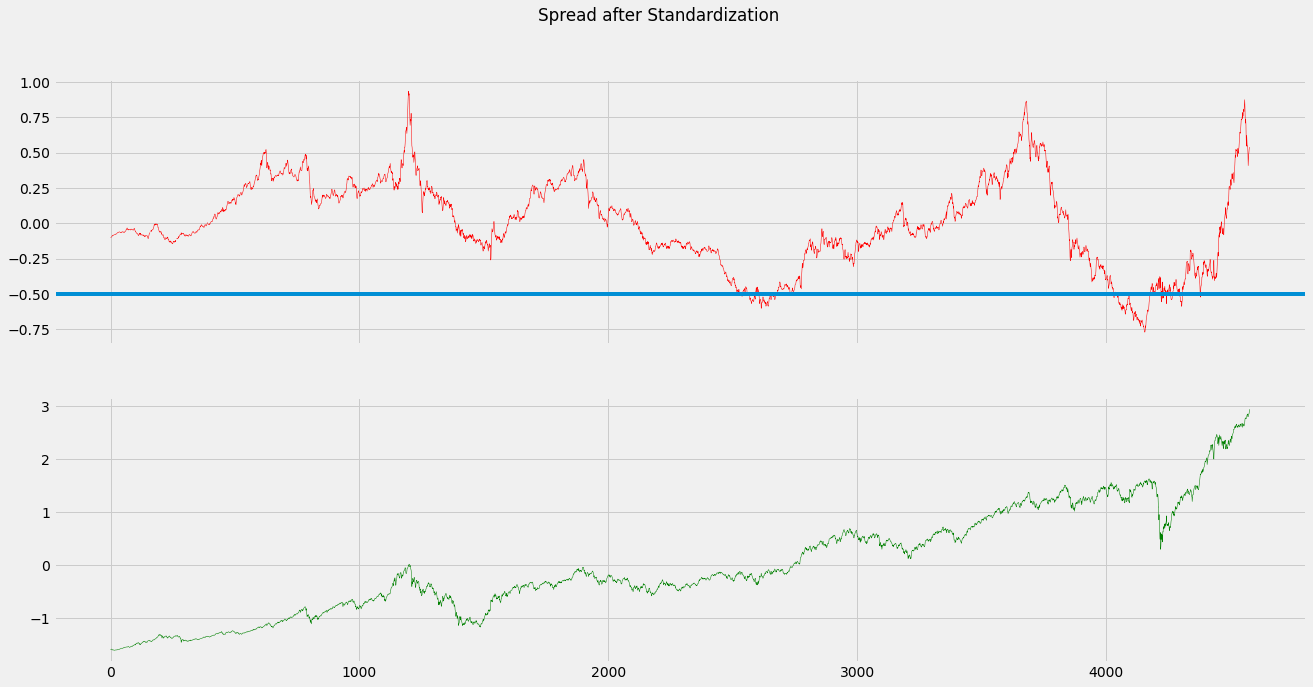

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(standard_df['diff'],linewidth=0.5,color='r')
ax[1].plot(standard_df['BSE 100'],linewidth=0.5,color='g')
ax[0].axhline(y=-0.5)
plt.suptitle('Spread after Standardization')
plt.show()

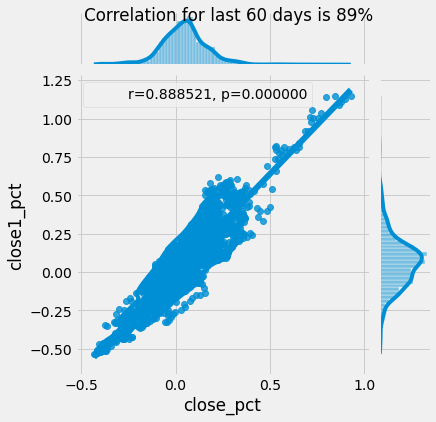

In [15]:
data_subset['close_pct']=data_subset['close'].pct_change(60)
data_subset['close1_pct']=data_subset['close1'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.suptitle(f'Correlation for last 60 days is {round(r*100)}%')
plt.show()